# Prerequisites

In [1]:
import sys

sys.path.append("..")

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.transforms.v2 as transforms
from matplotlib.colors import LinearSegmentedColormap
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision.models import resnet50
from torchvision.transforms.v2.functional import pad
from tqdm.notebook import tqdm

from dataset import HWSet, HWSetMasks, normalize_inv

C:\Users\runes\.conda\envs\context\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [3]:
data_dir = "../data"
class_legend = ("Siberian Husky", "Grey Wolf")

device = "cuda" if torch.cuda.is_available() else "cpu"

f"Using device: {device}"

'Using device: cuda'

# Normalization Constants

In [4]:
# dset = HWSetMasks(data_dir, "train", transform_shared=totensor, transform_img=None)

# for channel in range(3):
#     print(f'Channel {channel}')
#     print('Ordinary')
#     data = []
#     for idx in tqdm(range(len(dset))):
#         im, _, _ = dset[idx]
#         if im.shape[0] != 3:
#             continue
#         data.append(im[channel].ravel())
#     data = np.concatenate(data)
#     print(data.mean(), data.std())

#     print('No Context')
#     data = []
#     for idx in tqdm(range(len(dset))):
#         im, _, mask = dset[idx]
#         if im.shape[0] != 3:
#             continue
#         data.append((im * mask)[channel].ravel())
#     data = np.concatenate(data)
#     print(data.mean(), data.std())

In [5]:
norm_a = transforms.Normalize(mean=(0.453, 0.444, 0.403), std=(0.258, 0.255, 0.270))
norm_b = transforms.Normalize(mean=(0.152, 0.143, 0.133), std=(0.267, 0.255, 0.242))

norm_a_inv = transforms.Compose(
    [
        transforms.Normalize(
            mean=(0.0, 0.0, 0.0), std=(1 / 0.258, 1 / 0.255, 1 / 0.270)
        ),
        transforms.Normalize(mean=(-0.453, -0.444, -0.403), std=(1.0, 1.0, 1.0)),
    ]
)
norm_b_inv = transforms.Compose(
    [
        transforms.Normalize(
            mean=(0.0, 0.0, 0.0), std=(1 / 0.267, 1 / 0.255, 1 / 0.242)
        ),
        transforms.Normalize(mean=(-0.152, -0.143, -0.133), std=(1.0, 1.0, 1.0)),
    ]
)

# Data

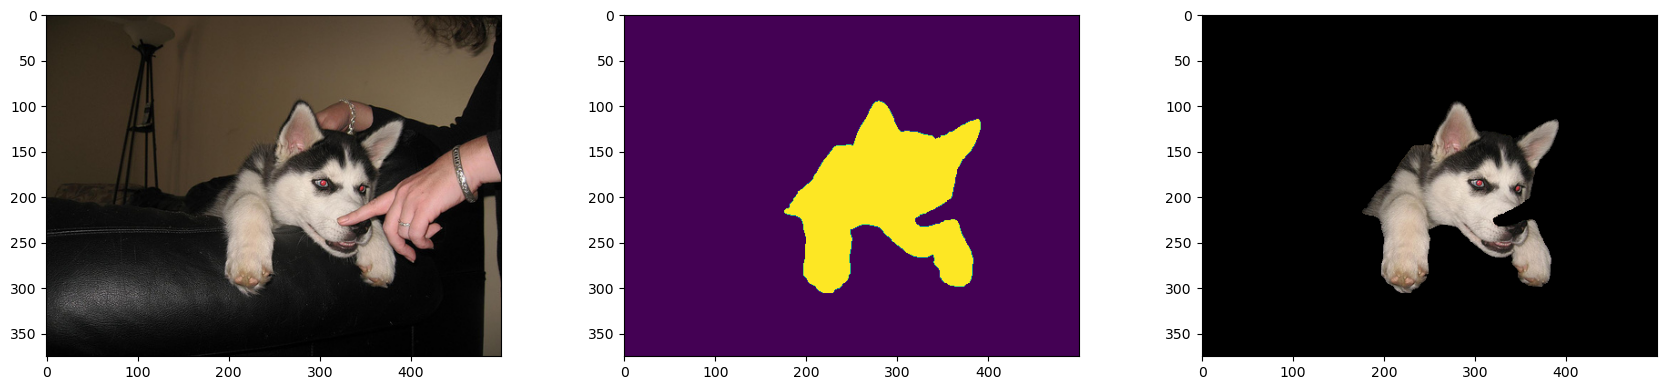

In [6]:
dset = HWSetMasks(data_dir, "train")

im, label, mask = dset[0]
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(18, 4), tight_layout=True)
ax0.imshow(im)
ax1.imshow(mask)
ax2.imshow(np.array(im) * (np.array(mask) > 0)[:, :, np.newaxis]);

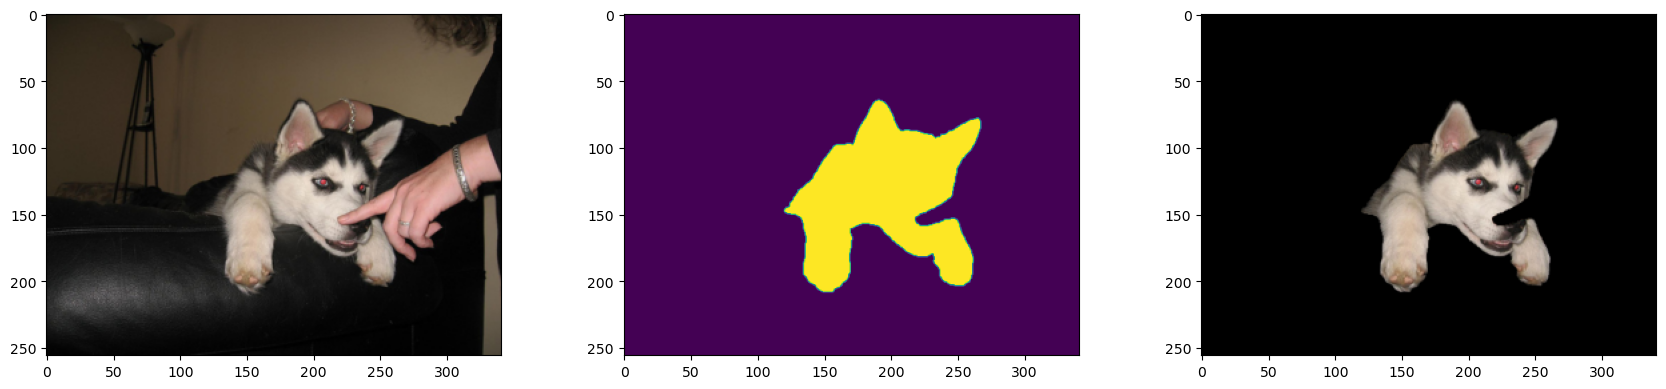

In [7]:
totensor = transforms.Compose(
    [transforms.ToImage(), transforms.ToDtype(torch.float32, scale=True)]
)

transform_shared = transforms.Compose(
    [transforms.Resize(256, antialias=True), totensor]
)

transform_img = transforms.Compose(
    [
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]
)

dset = HWSetMasks(
    data_dir, "train", transform_shared=transform_shared, transform_img=None
)

im, label, mask = dset[0]
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(18, 4), tight_layout=True)
ax0.imshow(np.moveaxis(im.numpy(), 0, -1))
ax1.imshow(np.moveaxis(mask.numpy(), 0, -1))
ax2.imshow(np.moveaxis((im * mask).numpy(), 0, -1));

# Models

In [8]:
def get_model(device="cpu", seed=191510):
    torch.manual_seed(seed)
    model = resnet50(weights=None)
    model.fc = torch.nn.Linear(
        in_features=2048, out_features=len(class_legend), bias=True
    )
    model.to(device)
    return model

In [9]:
model_a, model_b = get_model(device=device), get_model(device=device)

In [10]:
dloader = DataLoader(dset, batch_size=1)

In [11]:
img_batch, label_batch, mask_batch = next(iter(dloader))

preds_a = model_a(img_batch.to(device))
preds_b = model_b(img_batch.to(device))
preds_a, preds_b

(tensor([[0.9039, 0.7047]], device='cuda:0', grad_fn=<AddmmBackward0>),
 tensor([[0.9039, 0.7047]], device='cuda:0', grad_fn=<AddmmBackward0>))

# Dataloader

## Custom collate

In [12]:
def pad_collate_fn(data):
    """
    Args:
        data: A list of tuples with (image, label, mask) where:
            - 'image' is a tensor of arbitrary shape (e.g., [C, H, W])
            - 'label' is a scalar (integer)
            - 'mask' is a tensor of the same shape as the image
    Returns:
        batch: A dictionary containing the batched tensors:
            - 'images': A tensor of shape [batch_size, C, max_H, max_W]
            - 'labels': A tensor of shape [batch_size]
            - 'masks': A tensor of shape [batch_size, C, max_H, max_W]
    """
    images, labels, masks = zip(*data)

    # Determine the maximum height and width in the batch
    max_H = max(image.shape[1] for image in images)
    max_W = max(image.shape[2] for image in images)

    # Initialize tensors for batched data
    batch_size = len(images)
    n_channels = images[0].shape[0]
    batch_images = []
    batch_masks = []

    # Pad and stack images and masks
    for i, (image, mask) in enumerate(zip(images, masks)):
        h, w = image.shape[1], image.shape[2]
        diff_h, diff_w = max_H - h, max_W - w
        pad_h, pad_w = diff_h // 2, diff_w // 2
        padding = [pad_w + int(diff_w % 2), pad_h + int(diff_h % 2), pad_w, pad_h]
        batch_images.append(pad(image, padding))
        batch_masks.append(pad(mask, padding))

    # Convert labels to a tensor
    batch_labels = torch.tensor(labels)

    return (torch.stack(batch_images), batch_labels, torch.stack(batch_masks))

In [13]:
batch_size = 4
trainset = HWSetMasks(
    data_dir, "train", transform_shared=transform_shared, transform_img=transform_img
)
trainloader = DataLoader(
    trainset, batch_size=batch_size, collate_fn=pad_collate_fn, shuffle=True
)

256 341


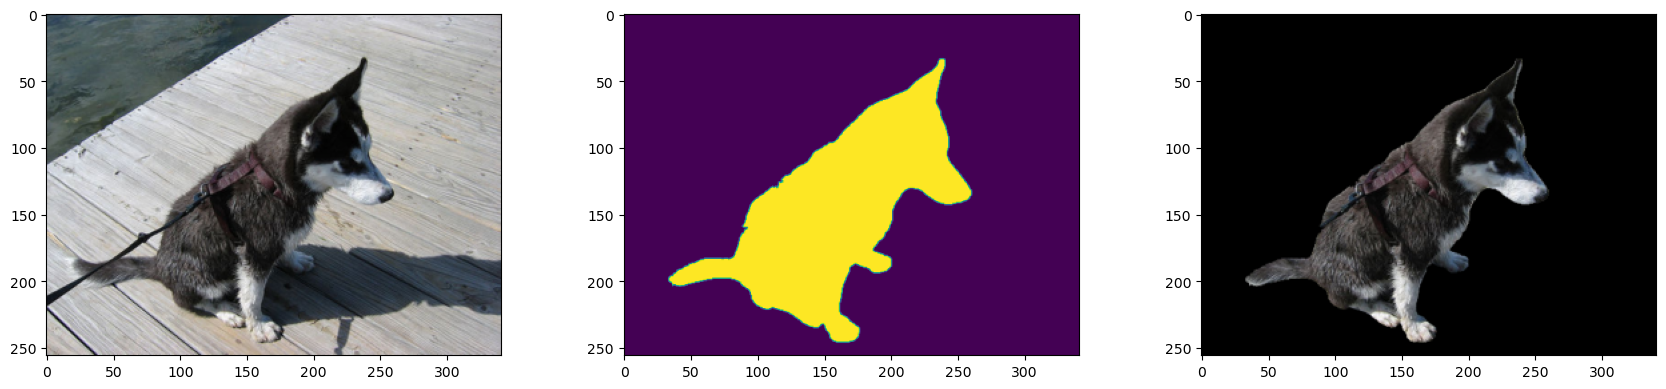

In [14]:
imgs, labels, masks = next(iter(trainloader))
im, label, mask = imgs[0], labels[0], masks[0]
im = normalize_inv(im)

fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(18, 4), tight_layout=True)
ax0.imshow(np.moveaxis(im.numpy(), 0, -1))
ax1.imshow(np.moveaxis(mask.numpy(), 0, -1))
ax2.imshow(np.moveaxis((im * mask).numpy(), 0, -1));

# Training step

In [15]:
batch_size = 2
num_workers = 0
lr = 1e-3

num_workers = min(num_workers, batch_size)

trainset = HWSetMasks(
    data_dir, "train", transform_shared=transform_shared, transform_img=transform_img
)
valset = HWSetMasks(
    data_dir, "val", transform_shared=transform_shared, transform_img=transform_img
)

trainloader = DataLoader(
    dset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=pad_collate_fn,
    num_workers=num_workers,
)
valloader = DataLoader(
    valset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=pad_collate_fn,
    num_workers=num_workers,
)

model_a, model_b = get_model(device=device), get_model(device=device)

criterion = torch.nn.CrossEntropyLoss()

optimizer_a = torch.optim.Adam(model_a.parameters(), lr=lr)
optimizer_b = torch.optim.Adam(model_b.parameters(), lr=lr)

In [16]:
def train_step(model, imgs, labels, optimizer, criterion, device="cpu", metrics=None):
    optimizer.zero_grad()
    out = model(imgs.to(device))

    loss = criterion(out, labels.type(torch.LongTensor).to(device))
    loss.backward()

    optimizer.step()

    optimizer.zero_grad()

    if metrics is not None:
        with torch.no_grad():
            score, indices = torch.max(out.cpu(), 1)
            metrics["loss"].append(loss.cpu().detach().item())
            metrics["preds"].append(indices.detach().numpy())
            metrics["scores"].append(score.detach().numpy())
            metrics["labels"].append(labels.numpy())

In [17]:
metrics_a = {"loss": [], "preds": [], "scores": [], "labels": []}
metrics_b = {"loss": [], "preds": [], "scores": [], "labels": []}

for imgs, labels, masks in tqdm(trainloader):
    model_a.train()
    model_b.train()
    train_step(
        model_a, imgs, labels, optimizer_a, criterion, device=device, metrics=metrics_a
    )
    train_step(
        model_b,
        imgs * masks,
        labels,
        optimizer_b,
        criterion,
        device=device,
        metrics=metrics_b,
    )
    break

  0%|          | 0/466 [00:00<?, ?it/s]

256 341
